In [189]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

In [338]:
df = pd.read_csv(r"dirty_mnist_2nd_answer.csv")
df.head()

,index,a,b,c,d,e,f,g,h,i,...,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,...,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,...,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,...,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,...,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,...,0,1,0,0,0,1,0,1,0,0


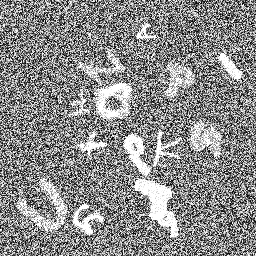

In [102]:
real = Image.open(r"C:\Users\user0721\Desktop\Hong\dirty_mnist\train\00000.png")
real

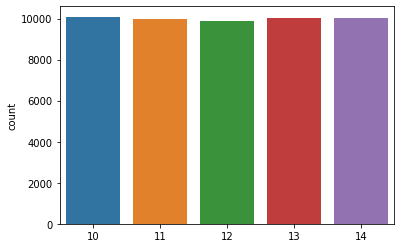

'\ntrain set은 총 5만장 label range 는 10~14\n'

In [339]:
sns.countplot(np.sum(df.iloc[:, 1:], axis=1))
plt.show()

"""
train set은 총 5만장 label range 는 10~14
"""

In [340]:
# emnist data 
df = pd.read_csv(r"mnist_data/train.csv")
df.head()

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,...,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,...,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,...,4,4,3,2,1,3,4,3,1,2


In [890]:
# emnist data dumy df
data = pd.concat((pd.get_dummies(df.letter), df[[str(i) for i in range(784)]]), axis=1)
data['letter'] = df['letter']

# sub data csv
sub_data_sum = 50000
sub_csv = pd.DataFrame(columns=pd.read_csv(r"dirty_mnist_2nd_answer.csv").columns.tolist(), index=range(sub_data_sum))

import torch
from torchvision import datasets, models, transforms

def create_directory(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
            
for e in range(sub_data_sum):
    # 넣을 알파벳 수 -> 10,11,12,13,14 중 1개 선택
    scope = np.random.choice(range(10, 15))

    # 넣을 알파벳 라벨 -> 26개중 scope비율 만큼 선택
    letter_set = np.random.choice(data["letter"].unique(), scope, replace=False)
    idx = [np.random.choice(data[data['letter'] == letter].index.tolist(), 1)[0] for letter in letter_set]
    subset = data.iloc[idx, :]
    
    # label 정보 저장
    sub_csv.iloc[e, 1:] = np.sum(subset.iloc[:, :26].values, axis=0)
    
    # 생성 이미지 affine 및 range 맞추기
    scales = [np.random.choice([0.1,0.15,0.2,0.25,0.3], size=1, p=[0.1,0.3,0.3,0.2,0.1])[0] for i in range(scope)]
    test_imgs = [Image.fromarray(data.iloc[i, 26:-1].values.reshape(28,28).astype(np.uint8)) for i in idx]
    test_imgs = [transforms.Compose([
                        transforms.Resize((256,256)),
                        transforms.RandomAffine(degrees=(-180, 180), translate=(0.4, 0.4),  scale=(scales[i], scales[i])),
                        transforms.ToTensor(),
                                        ])(img) for i, img in enumerate(test_imgs)]
    test_imgs = [torch.clip(img * (img > torch.median(img)), min=0, max=1.) for img in test_imgs]
    
    # 새로운 이미지
    field = torch.zeros((1,256,256))
    for i in test_imgs:
        field += i
    # 가우시안 노이즈 및 범위 조정
    field_clip = torch.clip((torch.clip(field, min=0, max=1.) + torch.rand((1,256,256))), min=0, max=1.)
    
    # 이미지 저장
    create_directory("sub_data")
    dir_path = "./sub_data/"
    save_path = dir_path + str(e).zfill(5) + '.png'
    test_save = transforms.ToPILImage()(field_clip)
    test_save.save(save_path, 'png')
    sub_csv.iloc[e, 0] = save_path
    
sub_csv.to_csv(r"sub_data.csv", index=False)

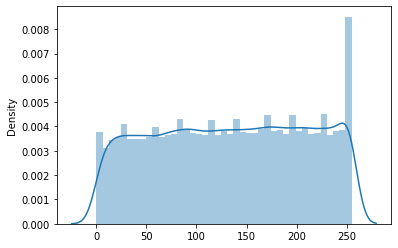

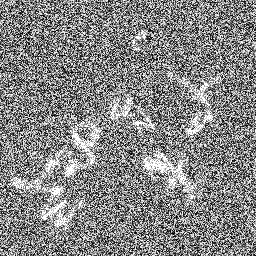

In [244]:
# norm img 
sns.distplot(np.array(transforms.ToPILImage()(field_norm)).flatten())
plt.show()

transforms.ToPILImage()(field_norm)

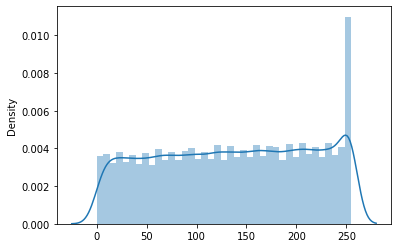

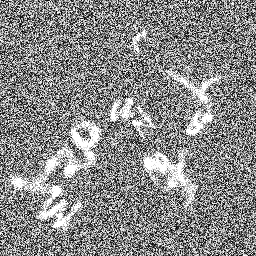

In [245]:
# clip img 
sns.distplot(np.array(transforms.ToPILImage()(field_clip)).flatten())
plt.show()

transforms.ToPILImage()(field_clip)

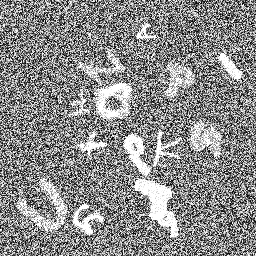

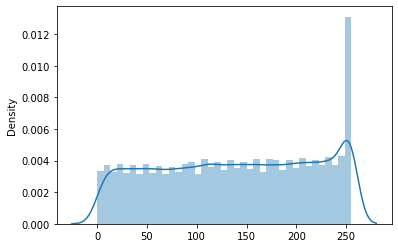

In [246]:
# real
sns.distplot(np.array(real))

real